In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math

from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from timeit import default_timer as timer

import warnings


# Preprocessing

In [2]:
# general preprocessor
# with MinMaxScaler
preprocessor = Pipeline(
   steps=[
       ("imputation", KNNImputer(n_neighbors=2, weights="uniform")),
       ("scaler", MinMaxScaler())
    ]
)
# without scaling
preprocessor_no_scaling = Pipeline(
   steps=[
       ("imputation", KNNImputer(n_neighbors=2, weights="uniform"))
    ]
)

In [3]:
# shuffling two objects in the same way
# input: two pandas objects whose orders correspond
# output: the input objects, but with shuffled order, but their orders still correspond
def shuffle(*objects):
    np.random.seed(42)
    new_index = np.random.permutation(objects[0].index)
    objects = [obj.reindex(new_index) for obj in objects]
    if len(objects) == 1: return objects[0]
    return objects


## Dataset 1: Biomed data on muscular dystropy

In [46]:
with open('data/biomed/preprocessed_biomed_data.pickle', 'rb') as handle:
    x_biomed_train, y_biomed_train, x_biomed_test, y_biomed_test = pickle.load(handle)



In [47]:
print(
    "Training features: ", x_biomed_train.shape, "\n",
    "Training labels: ", y_biomed_train.shape, "\n",
    "Test features: ", x_biomed_test.shape, "\n",
    "Test labels: ", y_biomed_test.shape, "\n",
    sep=""
)

Training features: (167, 5)
Training labels: (167,)
Test features: (42, 5)
Test labels: (42,)



## Dataset 2: Fertility

In [55]:
with open('data/fertility/fertility_preprocessed.pickle', 'rb') as handle:
    x_fert_train, y_fert_train, x_fert_test, y_fert_test = pickle.load(handle)

## Dataset 3: Amazon Reviews

In [56]:
with open('data/reviews/preprocessed_reviews_data.pickle', 'rb') as handle:
    x_reviews_train, y_reviews_train, x_reviews_test, y_reviews_test = pickle.load(handle)

## Dataset 4: Congress

In [40]:
with open('data/congress/preprocessed_congress_data.pickle', 'rb') as handle:
    x_congress_train, y_congress_train, x_congress_test, y_congress_test = pickle.load(handle)

# Prediction

The following datasets have the following variables to use for the prediction:

- Biomed: `x_biomed_train`, `y_biomed_train`, `x_biomed_test`, `y_biomed_test`
- Fertility: `x_fert_train`, `y_fert_train`, `x_fert_test`, `y_fert_test`
- Reviews: `x_reviews_train`, `y_reviews_train`, `x_reviews_test`
- Congress: `x_congress_train`, `y_congress_train`, `x_congress_test`




## Classifier 1: KNN

## Classifier 2: Decision Trees

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Parameters

In [42]:
# lists of parameters

# number of trees in the forest
n_estimators_list=[10,20,100,200] #default=100

# split goodness measure/criterion
# tree-specific parameter
# 'simple' error rate such as discussed in the lecture is not an option in sklearn
# "gini" for Gini-impurity, “log_loss” and “entropy” both for the Shannon information gain (=the same???)
criterion_list=["gini", "entropy","log_loss"] #default="gini"

### different stopping criteria to avoid fully grown trees, tree-specific parameters, "pre-pruning"
## maximum depth of the tree
# If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
max_depth_list=[None, 10, 20] #default=None
## minimum number of samples required to split an internal node
min_samples_split_list=[2,5,10] #default=2
## minimum number of samples required to be at a leaf node
# for smoothing the model, especially in regression. we will not consider it here, i.e. leave default=1
# min_samples_leaf_list=[1]# default=1
## minimum weighted fraction of the sum total of weights
# not considered here, i.e. 0.0
# min_weight_fraction_leaf=[0.0], default=0.0
## number of features to consider when looking for the best split ???
max_features_list=["sqrt", "log2", None] #default="sqrt"
## maximum number of leaf nodes
# not considered here, i.e. None
# max_leaf_nodes_list=[] default=None
## minimum impurity decrease: node will be split if split induces a decrease of impurity >= this value
# min_impurity_decrease_list=[], default=0.0

## botstrap:default=True, If False, the whole dataset is used to build each tree.
bootstrap_list=[True,False]

In [48]:
x_train = x_biomed_train
y_train = y_biomed_train
x_test = x_biomed_test
y_test = y_biomed_test
rf_1 = RandomForestClassifier(n_estimators=n_estimators_list[0],
                            criterion=criterion_list[0],
                            max_depth=max_depth_list[0],
                            min_samples_split=min_samples_split_list[0],
                            max_features=max_features_list[0],
                            random_state=0)
rf_1.fit(x_train,y_train)
print(rf_1.score(x_test, y_test))

0.9047619047619048


### Cross-validated grid-search over a parameter grid

refits=True: Automatically refits the best model on the entire training set. Disabling refitting might be useful if you only want to perform hyperparameter tuning and plan to train the final model separately on the entire training set with the best hyperparameters.\
Custom refit strategy: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py \
Visualizing multiple metric parameter search: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

In [49]:
chosen_random_state=17
k_cv=5
scoring_list=["balanced_accuracy","accuracy","recall","recall_weighted","recall_micro","recall_macro","precision","average_precision","precision_weighted","precision_micro","precision_macro","f1","f1_weighted","f1_micro","f1_macro"]
### for random forest classifier
rf=RandomForestClassifier(random_state=chosen_random_state)
param_grid_rf={'n_estimators':n_estimators_list,
           'criterion':criterion_list,
           'max_depth':max_depth_list,
           'min_samples_split':min_samples_split_list,
           'max_features':max_features_list,
           'bootstrap':bootstrap_list}
grid_search_rf=GridSearchCV(rf,param_grid_rf,cv=k_cv, scoring=scoring_list, refit=False)
# column mapping for table representing of results
column_mapping_rf = {'param_criterion': 'criterion',
                  'param_n_estimators': 'n_estimators',
                  'param_bootstrap': 'bootstrap',
                  'param_max_depth': 'max_depth',
                  'param_max_features': 'max_features',
                  'param_min_samples_split': 'min_samples_split',
                  'mean_test_balanced_accuracy':'balanced_accuracy',
                  'mean_test_accuracy':'accuracy',
                  'mean_test_recall':'recall',
                  'mean_test_recall_weighted':'recall_weighted',
                  'mean_test_recall_micro':'recall_micro',
                  'mean_test_recall_macro':'recall_macro',
                  'mean_test_precision':'precision',
                  'mean_test_average_precision':'average_precision',
                  'mean_test_precision_weighted':'precision_weighted',
                  'mean_test_precision_micro':'precision_micro',
                  'mean_test_precision_macro':'precision_macro',
                  'mean_test_f1':'f1',
                  'mean_test_f1_weighted':'f1_weighted',
                  'mean_test_f1_micro':'f1_micro',
                  'mean_test_f1_macro':'f1_macro',
                  'mean_score_time':'score_time',
                  'mean_fit_time':'fit_time'}

### RF: biomed

In [50]:
execute_biomed_gridsearch=False

In [423]:
x_train=x_biomed_train
y_train=y_biomed_train
if execute_biomed_gridsearch==True:
    grid_search_rf_biomed=grid_search_rf.fit(x_train,y_train)
    biomed_rf_results = pd.DataFrame({new_col: grid_search_rf_biomed.cv_results_[orig_col] for orig_col, new_col in column_mapping_rf.items()})
    # saving the results as a pickle
    with open('data/biomed/biomed_rf_results.pickle', 'wb') as handle:
        pickle.dump(biomed_rf_results, handle)
    biomed_rf_results.to_csv("data/biomed/biomed_rf_results.csv")

In [354]:
# loading the saved results
with open('data/biomed/biomed_rf_results.pickle', 'rb') as handle:
    biomed_rf_train_results = pickle.load(handle)

biomed_rf_train_results
#grid_search_rf_biomed

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,score_time,fit_time
0,gini,10,True,None,sqrt,2,0.819913,0.843672,0.733333,0.843672,...,0.848898,0.854539,0.843672,0.850918,0.767921,0.839786,0.843672,0.824181,0.035641,0.016815
1,gini,20,True,None,sqrt,2,0.811364,0.837433,0.716667,0.837433,...,0.867085,0.844827,0.837433,0.840193,0.751867,0.831841,0.837433,0.814512,0.032941,0.024759
2,gini,100,True,None,sqrt,2,0.841342,0.861854,0.766667,0.861854,...,0.902116,0.872788,0.861854,0.869679,0.796739,0.858971,0.861854,0.845430,0.050382,0.119804
3,gini,200,True,None,sqrt,2,0.867100,0.885740,0.800000,0.885740,...,0.903151,0.895751,0.885740,0.894838,0.831214,0.883144,0.885740,0.871845,0.069145,0.250371
4,gini,10,True,None,sqrt,5,0.845671,0.867558,0.766667,0.867558,...,0.888922,0.874041,0.867558,0.872831,0.807136,0.865275,0.867558,0.852646,0.036226,0.015635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,log_loss,200,False,20,None,5,0.820346,0.825668,0.800000,0.825668,...,0.713953,0.839608,0.825668,0.820783,0.766935,0.825536,0.825668,0.812780,0.078019,0.272686
644,log_loss,10,False,20,None,10,0.816991,0.825847,0.783333,0.825847,...,0.749109,0.852648,0.825847,0.840044,0.765267,0.823977,0.825847,0.811195,0.040604,0.016359
645,log_loss,20,False,20,None,10,0.816991,0.825847,0.783333,0.825847,...,0.747571,0.852648,0.825847,0.840044,0.765267,0.823977,0.825847,0.811195,0.041163,0.029139
646,log_loss,100,False,20,None,10,0.816991,0.825847,0.783333,0.825847,...,0.749109,0.852648,0.825847,0.840044,0.765267,0.823977,0.825847,0.811195,0.057243,0.126447


#### Plotting parameter variations

In [54]:
# vary n_estimators, other parameters default
grid_search_rf_n_estimators=GridSearchCV(rf,{'n_estimators':range(10, 801, 50)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if True:
    biomed_n_estimators_results=grid_search_rf_n_estimators.fit(x_biomed_train, y_biomed_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_min_samples_split=GridSearchCV(rf,{'min_samples_split':range(2, 203, 10)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    biomed_min_samples_split_results=grid_search_rf_min_samples_split.fit(x_biomed_train, y_biomed_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_max_depth=GridSearchCV(rf,{'max_depth':range(1, 31, 2)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    biomed_max_depth_results=grid_search_rf_max_depth.fit(x_biomed_train, y_biomed_train).cv_results_

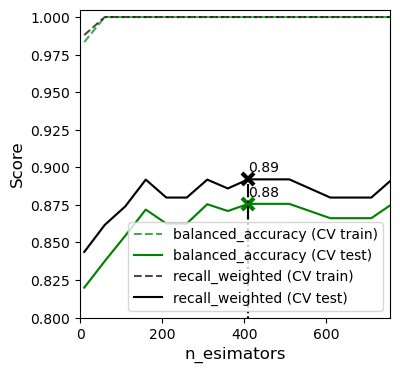

In [612]:
# plot n_estimators variation
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_esimators", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 756)
ax.set_ylim(0.8, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(biomed_n_estimators_results["param_n_estimators"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'recall_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = biomed_n_estimators_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_n_estimators_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(biomed_n_estimators_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = biomed_n_estimators_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('data/biomed/biomed_n_estimators_var.svg')
plt.show()

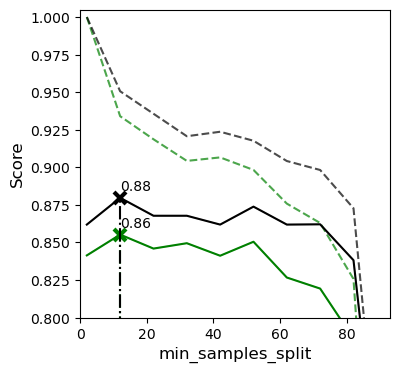

In [653]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 93)
ax.set_ylim(0.8, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(biomed_min_samples_split_results["param_min_samples_split"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'recall_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = biomed_min_samples_split_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_min_samples_split_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(biomed_min_samples_split_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = biomed_min_samples_split_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/biomed/biomed_min_samples_split_var.svg')
plt.show()

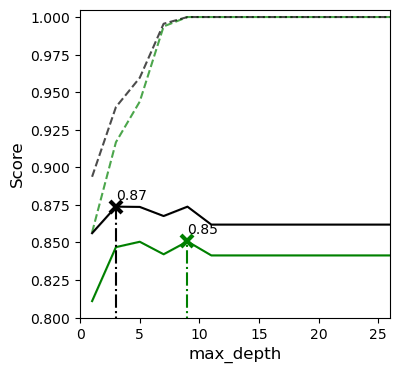

In [603]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 26)
ax.set_ylim(0.8, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(biomed_max_depth_results["param_max_depth"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'recall_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = biomed_max_depth_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_max_depth_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(biomed_max_depth_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = biomed_max_depth_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

#plt.legend(loc="best")
plt.grid(False)
plt.savefig('data/biomed/biomed_max_depth_var.svg')
plt.show()

In [355]:
best_accuracy_params_biomed_rf = biomed_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[0][['criterion','n_estimators','max_depth','max_features','min_samples_split']]
best_f1_params_biomed_rf = biomed_rf_train_results.sort_values(by='f1_weighted', ascending=False).iloc[0][['criterion','n_estimators','max_depth','max_features','min_samples_split']]
best_recall_params_biomed_rf = biomed_rf_train_results.sort_values(by='recall_weighted', ascending=False).iloc[0][['criterion','n_estimators','max_depth','max_features','min_samples_split']]
best_precision_params_biomed_rf = biomed_rf_train_results.sort_values(by='precision_weighted', ascending=False).iloc[0][['criterion','n_estimators','max_depth','max_features','min_samples_split']]
best_time_params_biomed_rf = biomed_rf_train_results.sort_values(by='fit_time', ascending=True).iloc[0][['criterion','n_estimators','max_depth','max_features','min_samples_split']]

# Display the best parameters
print("Best Parameters for Accuracy:\n", best_accuracy_params_biomed_rf)
print("Best Parameters for f1:\n", best_f1_params_biomed_rf)
print("Best Parameters for Recall:\n", best_recall_params_biomed_rf)
print("Best Parameters for Precision:\n", best_precision_params_biomed_rf)
print("Best Parameters for Time:\n", best_time_params_biomed_rf)

Best Parameters for Accuracy:
 criterion            log_loss
n_estimators              100
max_depth                  10
max_features             sqrt
min_samples_split          10
Name: 586, dtype: object
Best Parameters for f1:
 criterion            log_loss
n_estimators              100
max_depth                None
max_features             sqrt
min_samples_split          10
Name: 550, dtype: object
Best Parameters for Recall:
 criterion            log_loss
n_estimators              100
max_depth                None
max_features             sqrt
min_samples_split          10
Name: 550, dtype: object
Best Parameters for Precision:
 criterion            gini
n_estimators           20
max_depth              10
max_features         sqrt
min_samples_split       5
Name: 41, dtype: object
Best Parameters for Time:
 criterion            gini
n_estimators           10
max_depth            None
max_features         sqrt
min_samples_split       5
Name: 328, dtype: object


In [356]:
#biomed_rf_train_results.sort_values(by='time_taken', ascending=True).head(20)
#biomed_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).head(20)
#biomed_rf_train_results.sort_values(by='recall_weighted', ascending=False).head(20)

In [357]:
#biomed_rf_train_results.sort_values(by='recall_weighted', ascending=True).iloc[0]

In [358]:
#biomed_rf_train_results.sort_values(by='time_taken', ascending=True).iloc[0]

In [359]:
biomed_best_balanced_accuracy_params=biomed_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[0]
biomed_best_weighted_recall_params=biomed_rf_train_results.sort_values(by='recall_weighted', ascending=False).iloc[0]
biomed_example_params=biomed_rf_train_results.sort_values(by='recall_weighted', ascending=False).iloc[6]
biomed_example_params=biomed_rf_train_results.sort_values(by='fit_time', ascending=True).iloc[0]

#### run RF with different hyperparameters on biomed test sets

In [360]:
x_train = x_biomed_train
y_train = y_biomed_train
x_test = x_biomed_test
y_test = y_biomed_test
biomed_best_weighted_recall_rf = RandomForestClassifier(criterion=biomed_best_weighted_recall_params[0],
                            n_estimators=biomed_best_weighted_recall_params[1],
                            bootstrap=biomed_best_weighted_recall_params[2],
                            max_depth=biomed_best_weighted_recall_params[3],
                            max_features=biomed_best_weighted_recall_params[4],
                            min_samples_split=biomed_best_weighted_recall_params[5],
                            random_state=chosen_random_state)
biomed_best_weighted_recall_rf.fit(x_train,y_train)
biomed_pred_best_weighted_recall_rf=biomed_best_weighted_recall_rf.predict(x_test)
print('RF-Hyperparameters for best weighted recall \"Biomed\":\n',biomed_best_weighted_recall_params[0:6])
print('Weighted recall:', metrics.recall_score(y_test, biomed_pred_best_weighted_recall_rf, average='weighted'))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, biomed_pred_best_weighted_recall_rf))
#unscaled data
x_train = x_biomed_train
y_train = y_biomed_train
x_test = x_biomed_test
y_test = y_biomed_test
biomed_best_weighted_recall_rf.fit(x_train,y_train)
biomed_pred_best_weighted_recall_rf=biomed_best_weighted_recall_rf.predict(x_test)
#print('RF-Hyperparameters for best weighted recall \"Biomed\":\n',biomed_best_weighted_recall_params[0:6])
biomed_unscaled_cv = cross_validate(biomed_best_weighted_recall_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
print('Weighted recall CV unscaled:', biomed_unscaled_cv['test_recall_weighted'].mean())
print('Balanced accuracy CV unscaled:', biomed_unscaled_cv['test_balanced_accuracy'].mean())
print('Weighted F1 CV unscaled:', biomed_unscaled_cv['test_f1_weighted'].mean())
print('Weighted precision CV unscaled:', biomed_unscaled_cv['test_precision_weighted'].mean())
print('Fit time CV unscaled:', biomed_unscaled_cv['fit_time'].mean())
print('Weighted recall unscaled:', metrics.recall_score(y_test, biomed_pred_best_weighted_recall_rf, average='weighted'))
print('Balanced accuracy unscaled:', metrics.balanced_accuracy_score(y_test, biomed_pred_best_weighted_recall_rf))

In [361]:
#biomed_unscaled_cv#['test_balanced_accuracy'].mean()

In [362]:
biomed_best_weighted_recall_cv

0.8857397504456328

In [363]:
x_train = x_biomed_train
y_train = y_biomed_train
x_test = x_biomed_test
y_test = y_biomed_test
biomed_example_rf = RandomForestClassifier(criterion=biomed_example_params[0],
                            n_estimators=biomed_example_params[1],
                            bootstrap=biomed_example_params[2],
                            max_depth=biomed_example_params[3],
                            max_features=biomed_example_params[4],
                            min_samples_split=biomed_example_params[5],
                            random_state=chosen_random_state)
biomed_example_rf.fit(x_train,y_train)
biomed_pred_example_rf=biomed_example_rf.predict(x_test)
print('RF-Hyperparameters for example \"Biomed\":\n',biomed_example_params[0:6])
print('Weighted recall:', metrics.recall_score(y_test, biomed_pred_example_rf, average='weighted'))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, biomed_pred_example_rf))
#unscaled data
x_train = x_biomed_train
y_train = y_biomed_train
x_test = x_biomed_test
y_test = y_biomed_test
biomed_example_rf.fit(x_train,y_train)
biomed_pred_example_rf=biomed_example_rf.predict(x_test)
print('Weighted recall:', metrics.recall_score(y_test, biomed_pred_example_rf, average='weighted'))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, biomed_pred_example_rf))

In [364]:
biomed_best_balanced_accuracy_rf = RandomForestClassifier(criterion=biomed_best_balanced_accuracy_params[0],
                            n_estimators=biomed_best_balanced_accuracy_params[1],
                            bootstrap=biomed_best_balanced_accuracy_params[2],
                            max_depth=biomed_best_balanced_accuracy_params[3],
                            max_features=biomed_best_balanced_accuracy_params[4],
                            min_samples_split=biomed_best_balanced_accuracy_params[5],
                            random_state=chosen_random_state)
biomed_best_balanced_accuracy_rf.fit(x_train,y_train)
biomed_pred_best_balanced_accuracy_rf=biomed_best_balanced_accuracy_rf.predict(x_test)
print('RF-Hyperparameters for best balanced accuracy \"Biomed\":\n',biomed_best_balanced_accuracy_params[0:6])
print('Weighted recall:', metrics.recall_score(y_test, biomed_pred_best_balanced_accuracy_rf, average='weighted'))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, biomed_pred_best_balanced_accuracy_rf))
#print(best_weighted_recall_rf.predict(x_test))

RF-Hyperparameters for best balanced accuracy "Biomed":
 criterion            log_loss
n_estimators              100
bootstrap               False
max_depth                  10
max_features             sqrt
min_samples_split          10
Name: 586, dtype: object
Weighted recall: 0.8809523809523809
Balanced accuracy: 0.8333333333333333


### RF: Fertility

In [365]:
execute_fert_gridsearch=False

In [366]:
x_train=x_fert_train
y_train=y_fert_train
if execute_fert_gridsearch==True:
    warnings.filterwarnings('ignore')
    grid_search_rf_fertility=grid_search_rf.fit(x_train,y_train)
    fertility_rf_train_results = pd.DataFrame({new_col: grid_search_rf_fertility.cv_results_[orig_col] for orig_col, new_col in column_mapping_rf.items()})
    # saving the results as a pickle
    with open('data/fertility/fertility_rf_train_results.pickle', 'wb') as handle:
        pickle.dump(fertility_rf_train_results, handle)
    fertility_rf_train_results.to_csv("data/fertility/fertility_rf_train_results.csv")

In [345]:
# loading the saved results
with open('data/fertility/fertility_rf_train_results.pickle', 'rb') as handle:
    fertility_rf_train_results = pickle.load(handle)

#fertility_rf_train_results

In [244]:
fertility_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).head()

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,precision,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,time_taken
387,gini,200,False,10,None,2,0.621429,0.7875,0.4,0.7875,...,0.4,0.278333,0.842949,0.7875,0.653114,0.363333,0.80628,0.7875,0.616446,0.082065
420,gini,10,False,20,None,2,0.621429,0.7875,0.4,0.7875,...,0.4,0.275000,0.842949,0.7875,0.653114,0.363333,0.80628,0.7875,0.616446,0.035676
349,gini,20,False,None,None,2,0.621429,0.7875,0.4,0.7875,...,0.4,0.275000,0.842949,0.7875,0.653114,0.363333,0.80628,0.7875,0.616446,0.034340
348,gini,10,False,None,None,2,0.621429,0.7875,0.4,0.7875,...,0.4,0.275000,0.842949,0.7875,0.653114,0.363333,0.80628,0.7875,0.616446,0.033280
384,gini,10,False,10,None,2,0.621429,0.7875,0.4,0.7875,...,0.4,0.275000,0.842949,0.7875,0.653114,0.363333,0.80628,0.7875,0.616446,0.034963


In [521]:
#fertility_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[0]

In [229]:
fertility_rf_train_results.sort_values(by='f1_weighted', ascending=False).head()

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,precision,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,time_taken
1026,log_loss,100,False,20,sqrt,5,0.592857,0.8875,0.2,0.8875,...,0.4,0.351389,0.834583,0.8875,0.648333,0.266667,0.854828,0.8875,0.602759,0.059642
606,gini,100,False,10,sqrt,5,0.592857,0.8875,0.2,0.8875,...,0.4,0.349217,0.834583,0.8875,0.648333,0.266667,0.854828,0.8875,0.602759,0.064622
858,entropy,100,False,20,log2,5,0.592857,0.8875,0.2,0.8875,...,0.4,0.351389,0.834583,0.8875,0.648333,0.266667,0.854828,0.8875,0.602759,0.062777
303,entropy,200,True,20,sqrt,2,0.592857,0.8875,0.2,0.8875,...,0.4,0.383355,0.834583,0.8875,0.648333,0.266667,0.854828,0.8875,0.602759,0.075995
315,entropy,200,True,20,log2,2,0.592857,0.8875,0.2,0.8875,...,0.4,0.383355,0.834583,0.8875,0.648333,0.266667,0.854828,0.8875,0.602759,0.073681


In [260]:
#fertility_rf_train_results.sort_values(by='f1_weighted', ascending=False).iloc[0]

In [261]:
#fertility_rf_train_results.sort_values(by='precision_weighted', ascending=False).iloc[0]

In [519]:
#fertility_rf_train_results.sort_values(by='fit_time', ascending=True).iloc[0]

In [533]:
x_fert_train.shape

(80, 20)

#### Plotting parameter variations

In [550]:
# vary n_estimators, other parameters default
grid_search_rf_n_estimators=GridSearchCV(rf,{'n_estimators':range(10, 101, 10)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    fertility_n_estimators_results=grid_search_rf_n_estimators.fit(x_fert_train, y_fert_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_min_samples_split=GridSearchCV(rf,{'min_samples_split':range(2, 17, 2)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    fertility_min_samples_split_results=grid_search_rf_min_samples_split.fit(x_fert_train, y_fert_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_max_depth=GridSearchCV(rf,{'max_depth':range(1, 16, 2)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    fertility_max_depth_results=grid_search_rf_max_depth.fit(x_fert_train, y_fert_train).cv_results_

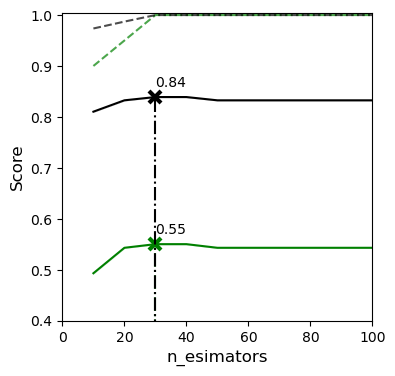

In [614]:
# plot n_estimators variation
plt.figure(figsize=(4, 4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_esimators", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 100)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(fertility_n_estimators_results["param_n_estimators"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = fertility_n_estimators_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = fertility_n_estimators_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(fertility_n_estimators_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = fertility_n_estimators_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/fertility/fertility_n_estimators_var.svg')
plt.show()

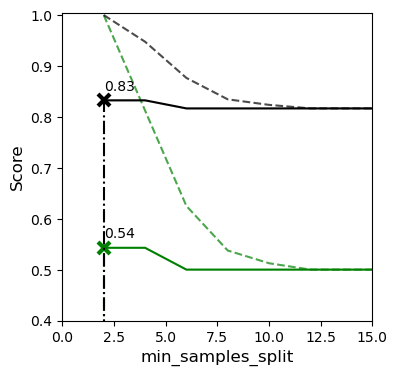

In [583]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 15)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(fertility_min_samples_split_results["param_min_samples_split"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = fertility_min_samples_split_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = fertility_min_samples_split_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(fertility_min_samples_split_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = fertility_min_samples_split_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
plt.savefig('data/fertility/fertility_min_samples_split_var.svg')
plt.show()

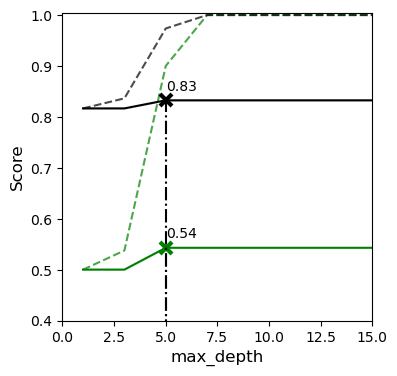

In [584]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 15)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(fertility_max_depth_results["param_max_depth"].data, dtype=float)
scoring_list_plot=['balanced_accuracy', 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = fertility_max_depth_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_max_depth_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(fertility_max_depth_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = fertility_max_depth_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
plt.savefig('data/fertility/fertility_max_depth_var.svg')
plt.show()

#### run RF with different hyperparameters on fertility test sets

In [263]:
fertility_example_params=fertility_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[0]
fertility_example_params=fertility_rf_train_results.sort_values(by='f1_weighted', ascending=False).iloc[0]
fertility_example_params=fertility_rf_train_results.sort_values(by='precision_weighted', ascending=False).iloc[0]
fertility_example_params=fertility_rf_train_results.sort_values(by='fit_time', ascending=True).iloc[0]

In [264]:
x_train = x_fert_train
y_train = y_fert_train
x_test = x_fert_test
y_test = y_fert_test
fertility_example_rf = RandomForestClassifier(criterion=fertility_example_params[0],
                            n_estimators=fertility_example_params[1],
                            bootstrap=fertility_example_params[2],
                            max_depth=fertility_example_params[3],
                            max_features=fertility_example_params[4],
                            min_samples_split=fertility_example_params[5],
                            random_state=chosen_random_state)
fertility_example_rf.fit(x_train,y_train)
fertility_pred_example_rf=fertility_example_rf.predict(x_test)
print('RF-Hyperparameters for example \"Biomed\":\n',fertility_example_params[0:6])
print('Weighted recall:', metrics.recall_score(y_test, fertility_pred_example_rf, average='weighted'))
print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, fertility_pred_example_rf))
print('F1:', metrics.f1_score(y_test, fertility_pred_example_rf, average='weighted'))
print('Precision:', metrics.precision_score(y_test, fertility_pred_example_rf, average='weighted'))
#print(best_weighted_recall_rf.predict(x_test))

RF-Hyperparameters for example "Biomed":
 criterion            gini
n_estimators           10
bootstrap            True
max_depth            None
max_features         log2
min_samples_split       2
Name: 12, dtype: object
Weighted recall: 0.85
Balanced accuracy: 0.4722222222222222
F1: 0.827027027027027
Precision: 0.8052631578947368


In [87]:
x_train = x_fert_train
y_train = y_fert_train
x_test = x_fert_test
y_test = y_fert_test
rf_fert_1 = RandomForestClassifier(n_estimators=n_estimators_list[0],
                            criterion=criterion_list[0],
                            max_depth=max_depth_list[0],
                            min_samples_split=min_samples_split_list[0],
                            max_features=max_features_list[0],
                            random_state=0)
rf_fert_1.fit(x_train,y_train)
print(rf_fert_1.score(x_test, y_test))
print(rf_fert_1.predict(x_test))

0.85
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


### RF: Reviews

In [418]:
max_depth_list, n_estimators_list

([None, 10, 20], [10, 20, 100, 200])

#### run RF with different hyperparameters on reviews training sets

In [654]:
execute_reviews_search=False

In [655]:
x_train=x_reviews_train
y_train=y_reviews_train
x_test=x_reviews_test
if execute_reviews_search==True:
    warnings.filterwarnings('ignore')
    reviews_rf = RandomForestClassifier(criterion=criterion_list[0],
                                n_estimators=1000,
                                bootstrap=bootstrap_list[1],
                                max_depth=max_depth_list[0],
                                max_features=max_features_list[0],
                                min_samples_split=min_samples_split_list[0],
                                random_state=chosen_random_state)
    reviews_rf.fit(x_train,y_train)
    reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
    reviews_cv_rf_train_results = pd.DataFrame(reviews_cv)
    # saving the results as a pickle
    with open('data/reviews/reviews_cv_rf_train_results.pickle', 'wb') as handle:
        pickle.dump(reviews_cv_rf_train_results, handle)
    reviews_cv_rf_train_results.to_csv("data/reviews/reviews_cv_rf_train_results.csv")
    # predict test labels
    reviews_pred_rf=reviews_rf.predict(x_test)
    x_id_column=x_test.reset_index()
    reviews_rf_test_results=pd.DataFrame(x_test.reset_index()['index'])
    reviews_rf_test_results.columns=['ID']
    reviews_rf_test_results['class']=reviews_pred_rf
    reviews_rf_test_results.to_csv("data/reviews/reviews_rf_test_results.csv", index=False)

In [656]:
# loading the saved results
with open('data/reviews/reviews_cv_rf_train_results.pickle', 'rb') as handle:
    reviews_cv_rf_train_results = pickle.load(handle)

reviews_cv_rf_train_results

,fit_time,score_time,test_balanced_accuracy,test_accuracy,test_recall,test_recall_weighted,test_recall_micro,test_recall_macro,test_precision,test_average_precision,test_precision_weighted,test_precision_micro,test_precision_macro,test_f1,test_f1_weighted,test_f1_micro,test_f1_macro
0,18.581848,0.219213,0.658000,0.666667,NaN,0.666667,0.666667,0.658000,NaN,NaN,0.670921,0.666667,0.662952,NaN,0.636276,0.666667,0.629941
1,18.042738,0.230145,0.686667,0.706667,NaN,0.706667,0.706667,0.686667,NaN,NaN,0.765090,0.706667,0.758317,NaN,0.696391,0.706667,0.684186
2,18.392844,0.223215,0.663333,0.666667,NaN,0.666667,0.666667,0.663333,NaN,NaN,0.697095,0.666667,0.714405,NaN,0.647919,0.666667,0.654378
3,18.441525,0.248600,0.761667,0.773333,NaN,0.773333,0.773333,0.761667,NaN,NaN,0.799979,0.773333,0.796651,NaN,0.762238,0.773333,0.756393
4,18.785467,0.325397,0.730000,0.740000,NaN,0.740000,0.740000,0.730000,NaN,NaN,0.749643,0.740000,0.758119,NaN,0.717623,0.740000,0.716766


In [ ]:
reviews_cv_rf_train_results['test_balanced_accuracy'].mean()

In [ ]:
x_train = x_reviews_train
y_train = y_reviews_train
x_test = x_reviews_test
warnings.filterwarnings('ignore')
reviews_rf = RandomForestClassifier(criterion=criterion_list[0],
                            n_estimators=1000,
                            bootstrap=bootstrap_list[1],
                            max_depth=max_depth_list[0],
                            max_features=max_features_list[0],
                            min_samples_split=min_samples_split_list[0],
                            n_jobs=4,
                            random_state=chosen_random_state)
reviews_rf.fit(x_train,y_train)
reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)

In [ ]:
reviews_cv['test_balanced_accuracy'].mean(), reviews_cv['fit_time'].mean()

In [69]:
execute_reviews_gridsearch=False

In [60]:
x_train=x_reviews_train
y_train=y_reviews_train
if execute_reviews_gridsearch==True:
    #warnings.filterwarnings('ignore')
    grid_search_rf_reviews=grid_search_rf.fit(x_train,y_train)
    reviews_rf_train_results = pd.DataFrame({new_col: grid_search_rf_reviews.cv_results_[orig_col] for orig_col, new_col in column_mapping_rf.items()})
    # saving the results as a pickle
    with open('data/reviews/reviews_rf_train_results.pickle', 'wb') as handle:
        pickle.dump(reviews_rf_train_results, handle)
    reviews_rf_train_results.to_csv("data/reviews/reviews_rf_train_results.csv")

In [615]:
# loading the saved results
with open('data/reviews/reviews_rf_train_results.pickle', 'rb') as handle:
    reviews_rf_train_results = pickle.load(handle)

reviews_rf_train_results

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,precision,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,time_taken
0,gini,10,True,None,sqrt,2,0.257467,0.254667,NaN,0.254667,...,NaN,NaN,0.258063,0.254667,0.260522,NaN,0.234937,0.254667,0.237499,0.086834
1,gini,20,True,None,sqrt,2,0.362933,0.362667,NaN,0.362667,...,NaN,NaN,0.359745,0.362667,0.359877,NaN,0.334321,0.362667,0.335544,0.099465
2,gini,100,True,None,sqrt,2,0.557867,0.566667,NaN,0.566667,...,NaN,NaN,0.558473,0.566667,0.558407,NaN,0.535468,0.566667,0.532373,0.106290
3,gini,200,True,None,sqrt,2,0.605533,0.618667,NaN,0.618667,...,NaN,NaN,0.609549,0.618667,0.610513,NaN,0.587314,0.618667,0.582075,0.147597
4,gini,10,True,None,sqrt,5,0.300600,0.302667,NaN,0.302667,...,NaN,NaN,0.284352,0.302667,0.283821,NaN,0.277269,0.302667,0.275509,0.157019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,log_loss,200,False,20,20,5,0.336200,0.364000,NaN,0.364000,...,NaN,NaN,0.364278,0.364000,0.348289,NaN,0.323515,0.364000,0.304901,0.095995
1076,log_loss,10,False,20,20,10,0.154467,0.162667,NaN,0.162667,...,NaN,NaN,0.151278,0.162667,0.144791,NaN,0.143832,0.162667,0.136906,0.071050
1077,log_loss,20,False,20,20,10,0.198600,0.208000,NaN,0.208000,...,NaN,NaN,0.189597,0.208000,0.179944,NaN,0.184673,0.208000,0.175975,0.077155
1078,log_loss,100,False,20,20,10,0.333867,0.361333,NaN,0.361333,...,NaN,NaN,0.360921,0.361333,0.351055,NaN,0.319835,0.361333,0.304293,0.095793


In [620]:
reviews_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).head()

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,precision,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,time_taken
551,gini,200,False,None,sqrt,10,0.653400,0.665333,NaN,0.665333,...,NaN,NaN,0.675463,0.665333,0.674160,NaN,0.640520,0.665333,0.634713,0.089564
667,gini,200,False,20,sqrt,5,0.649800,0.662667,NaN,0.662667,...,NaN,NaN,0.667183,0.662667,0.663968,NaN,0.633093,0.662667,0.625670,0.085921
547,gini,200,False,None,sqrt,5,0.640667,0.652000,NaN,0.652000,...,NaN,NaN,0.658950,0.652000,0.655447,NaN,0.625483,0.652000,0.618926,0.087807
543,gini,200,False,None,sqrt,2,0.640600,0.657333,NaN,0.657333,...,NaN,NaN,0.648285,0.657333,0.641506,NaN,0.625164,0.657333,0.613737,0.102843
663,gini,200,False,20,sqrt,2,0.637133,0.648000,NaN,0.648000,...,NaN,NaN,0.637981,0.648000,0.639709,NaN,0.615077,0.648000,0.611105,0.086625


#### Plotting parameter variations

In [641]:
# vary n_estimators, other parameters default
grid_search_rf_n_estimators=GridSearchCV(rf,{'n_estimators':range(10, 1010, 100)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    reviews_n_estimators_results=grid_search_rf_n_estimators.fit(x_reviews_train, y_reviews_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_min_samples_split=GridSearchCV(rf,{'min_samples_split':range(2, 100, 10)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    reviews_min_samples_split_results=grid_search_rf_min_samples_split.fit(x_reviews_train, y_reviews_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_max_depth=GridSearchCV(rf,{'max_depth':range(1, 101, 10)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if True:
    reviews_max_depth_results=grid_search_rf_max_depth.fit(x_reviews_train, y_reviews_train).cv_results_

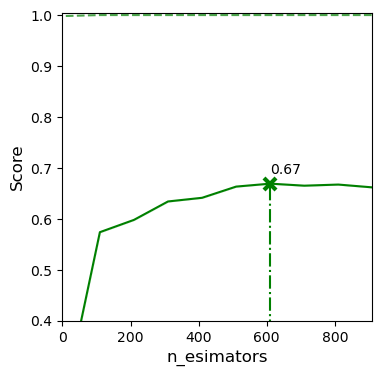

In [647]:
# plot n_estimators variation
plt.figure(figsize=(4, 4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_esimators", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 910)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(reviews_n_estimators_results["param_n_estimators"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#,'precision_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = reviews_n_estimators_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = reviews_n_estimators_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(reviews_n_estimators_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = reviews_n_estimators_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/reviews/reviews_n_estimators_var.svg')
plt.show()

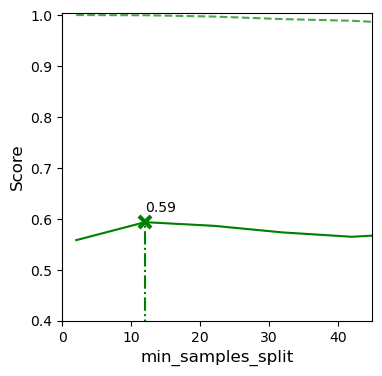

In [650]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 45)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(reviews_min_samples_split_results["param_min_samples_split"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#, 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = reviews_min_samples_split_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = reviews_min_samples_split_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(reviews_min_samples_split_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = reviews_min_samples_split_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
plt.savefig('data/reviews/reviews_min_samples_split_var.svg')
plt.show()

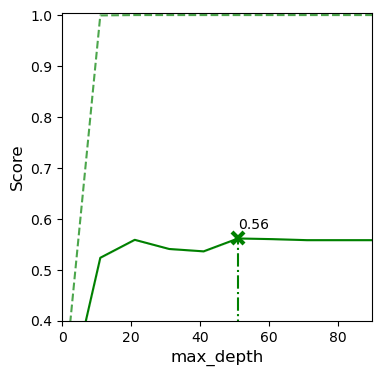

In [649]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 90)
ax.set_ylim(0.4, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(reviews_max_depth_results["param_max_depth"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#, 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = reviews_max_depth_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_max_depth_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(reviews_max_depth_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = reviews_max_depth_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.02))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/reviews/reviews_max_depth_var.svg')
plt.show()

In [887]:
x_train=x_reviews_train
y_train=y_reviews_train
x_test=x_reviews_test
if False:
    warnings.filterwarnings('ignore')
    reviews_rf = RandomForestClassifier(criterion='gini',
                                n_estimators=200,
                                bootstrap=False,
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_split=10,
                                random_state=chosen_random_state)
    reviews_rf.fit(x_train,y_train)
    reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
    reviews_cv_rf_train_results = pd.DataFrame(reviews_cv)

In [888]:
reviews_cv_rf_train_results['test_balanced_accuracy'].mean()
reviews_cv_rf_train_results['fit_time'].mean()

6.884880065917969

In [889]:
x_train=x_reviews_train
y_train=y_reviews_train
x_test=x_reviews_test
if False:
    warnings.filterwarnings('ignore')
    reviews_rf = RandomForestClassifier(criterion='gini',
                                n_estimators=600,
                                bootstrap=False,
                                max_depth=20,
                                max_features='sqrt',
                                min_samples_split=10,
                                random_state=chosen_random_state)
    reviews_rf.fit(x_train,y_train)
    reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
    reviews_cv_rf_train_results = pd.DataFrame(reviews_cv)

In [890]:
reviews_cv_rf_train_results['test_balanced_accuracy'].mean()
#reviews_cv_rf_train_results['fit_time'].mean()

0.6645333333333332

In [891]:
x_train=x_reviews_train
y_train=y_reviews_train
x_test=x_reviews_test
if False:
    warnings.filterwarnings('ignore')
    reviews_rf = RandomForestClassifier(criterion='gini',
                                n_estimators=600,
                                bootstrap=False,
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_split=10,
                                random_state=chosen_random_state)
    reviews_rf.fit(x_train,y_train)
    reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
    reviews_cv_rf_train_results = pd.DataFrame(reviews_cv)

In [892]:
reviews_cv_rf_train_results['test_balanced_accuracy'].mean()
reviews_cv_rf_train_results['fit_time'].mean()

6.884880065917969

In [893]:
x_train=x_reviews_train
y_train=y_reviews_train
x_test=x_reviews_test
if False:
    warnings.filterwarnings('ignore')
    reviews_rf = RandomForestClassifier(criterion='gini',
                                n_estimators=600,
                                bootstrap=False,
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_split=10,
                                random_state=chosen_random_state)
    reviews_rf.fit(x_train,y_train)
    reviews_cv = cross_validate(reviews_rf, x_train, y_train, scoring=scoring_list, cv=k_cv)
    reviews_cv_rf_train_results = pd.DataFrame(reviews_cv)

In [894]:
reviews_cv_rf_train_results['test_balanced_accuracy'].mean()
#reviews_cv_rf_train_results['fit_time'].mean()

0.6645333333333332

In [895]:
reviews_pred_rf=reviews_rf.predict(x_test)

In [896]:
reviews_pred_rf

array(['Wilson', 'Brown', 'Blankenship', 'Chandler', 'Messick', 'Vision',
       'Hayes', 'Kolln', 'Johnson', 'Mitchell', 'Morrison', 'Neal',
       'Morrison', 'Chachra', 'Kolln', 'Robert', 'Ashbacher', 'Neal',
       'Cutey', 'Mitchell', 'Walters', 'Chachra', 'Auken', 'Goonan',
       'Calvinnme', 'Mahlers2nd', 'Cutey', 'Blankenship', 'Mahlers2nd',
       'Davisson', 'Hayes', 'Cutey', 'Power', 'Davisson', 'Nigam',
       'Brown', 'Agresti', 'Ashbacher', 'Auken', 'Agresti', 'Wilson',
       'Davisson', 'Dent', 'Shea', 'CFH', 'Kolln', 'Nigam', 'Vernon',
       'Chell', 'Sherwin', 'Comdet', 'Nigam', 'Calvinnme', 'Comdet',
       'Kolln', 'Chachra', 'Engineer', 'Brown', 'Taylor', 'Dent',
       'Johnson', 'Nigam', 'Riley', 'Wilson', 'Chandler', 'Brown',
       'Messick', 'Dent', 'Nigam', 'Hayes', 'Cutey', 'Sherwin', 'Mark',
       'Johnson', 'Kolln', 'Kolln', 'Janson', 'Engineer', 'Engineer',
       'Shea', 'Calvinnme', 'Chachra', 'Lawyeraau', 'Nigam', 'Janson',
       'Chachra', 'Grove'

In [897]:
reviews_rf_test_results=pd.DataFrame(reviews_test_ID)
reviews_rf_test_results['class']=reviews_pred_rf
reviews_rf_test_results.to_csv("data/reviews/reviews_rf_test_results.csv", index=False)

In [898]:
pd.DataFrame(reviews_test_ID)

,ID
0,750
1,751
2,752
3,753
4,754
...,...
745,1495
746,1496
747,1497
748,1498


In [900]:
reviews_rf_test_results

,ID,class
0,750,Wilson
1,751,Brown
2,752,Blankenship
3,753,Chandler
4,754,Messick
...,...,...
745,1495,Janson
746,1496,Cutey
747,1497,Mahlers2nd
748,1498,Johnson


### RF: Congress

In [803]:
execute_congress_gridsearch=False

In [804]:
x_train=x_congress_train_processed
y_train=y_congress_train
if execute_congress_gridsearch==True:
    #warnings.filterwarnings('ignore')
    grid_search_rf_congress=grid_search_rf.fit(x_train,y_train)
    congress_rf_train_results = pd.DataFrame({new_col: grid_search_rf_congress.cv_results_[orig_col] for orig_col, new_col in column_mapping_rf.items()})
    # saving the results as a pickle
    with open('data/congress/congress_rf_train_results.pickle', 'wb') as handle:
        pickle.dump(congress_rf_train_results, handle)
    congress_rf_train_results.to_csv("data/congress/congress_rf_train_results.csv")

In [805]:
# loading the saved results
with open('data/congress/congress_rf_train_results.pickle', 'rb') as handle:
    congress_rf_train_results = pickle.load(handle)

congress_rf_train_results

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,score_time,fit_time
0,gini,10,True,None,sqrt,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.022499,0.015566
1,gini,20,True,None,sqrt,2,0.947950,0.954123,NaN,0.954123,...,NaN,0.957164,0.954123,0.956986,NaN,0.953862,0.954123,0.950421,0.019903,0.020602
2,gini,100,True,None,sqrt,2,0.941042,0.945032,NaN,0.945032,...,NaN,0.947397,0.945032,0.943871,NaN,0.944853,0.945032,0.940876,0.026215,0.094285
3,gini,200,True,None,sqrt,2,0.941042,0.945032,NaN,0.945032,...,NaN,0.947397,0.945032,0.943871,NaN,0.944853,0.945032,0.940876,0.035359,0.192308
4,gini,10,True,None,sqrt,5,0.947292,0.949683,NaN,0.949683,...,NaN,0.950402,0.949683,0.945943,NaN,0.949733,0.949683,0.946269,0.019665,0.011889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,log_loss,200,False,20,None,5,0.952021,0.958774,NaN,0.958774,...,NaN,0.960105,0.958774,0.961029,NaN,0.958646,0.958774,0.955606,0.034975,0.156622
644,log_loss,10,False,20,None,10,0.946792,0.949683,NaN,0.949683,...,NaN,0.954477,0.949683,0.951568,NaN,0.949785,0.949683,0.946666,0.020485,0.010051
645,log_loss,20,False,20,None,10,0.946792,0.949683,NaN,0.949683,...,NaN,0.954477,0.949683,0.951568,NaN,0.949785,0.949683,0.946666,0.022566,0.018609
646,log_loss,100,False,20,None,10,0.946792,0.949683,NaN,0.949683,...,NaN,0.954477,0.949683,0.951568,NaN,0.949785,0.949683,0.946666,0.028948,0.080841


In [806]:
congress_rf_train_results.sort_values(by='balanced_accuracy', ascending=False)#.iloc[0]
#congress_rf_train_results.sort_values(by='fit_time', ascending=True).iloc[0]

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,score_time,fit_time
177,entropy,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.021423,0.022860
285,log_loss,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020885,0.021263
321,log_loss,20,True,20,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020283,0.021379
69,gini,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.022470,0.021767
105,gini,20,True,20,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020065,0.021233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,gini,10,True,10,sqrt,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.020279,0.011633
12,gini,10,True,None,log2,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019191,0.011725
72,gini,10,True,20,sqrt,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019044,0.011601
48,gini,10,True,10,log2,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019340,0.011665


#### Plotting parameter variations

In [807]:
# vary n_estimators, other parameters default
grid_search_rf_n_estimators=GridSearchCV(rf,{'n_estimators':range(10, 510, 20)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    congress_n_estimators_results=grid_search_rf_n_estimators.fit(x_congress_train_processed, y_congress_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_min_samples_split=GridSearchCV(rf,{'min_samples_split':range(2, 100, 10)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    congress_min_samples_split_results=grid_search_rf_min_samples_split.fit(x_congress_train_processed, y_congress_train).cv_results_
# vary min_samples_split, other parameters default
grid_search_rf_max_depth=GridSearchCV(rf,{'max_depth':range(1, 21, 2)},cv=k_cv, scoring=scoring_list, refit=False,return_train_score=True,)
if False:
    congress_max_depth_results=grid_search_rf_max_depth.fit(x_congress_train_processed, y_congress_train).cv_results_

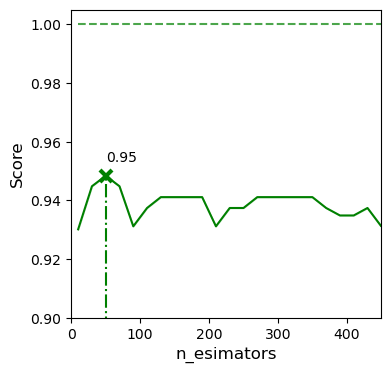

In [808]:
# plot n_estimators variation
plt.figure(figsize=(4, 4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_esimators", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 450)
ax.set_ylim(0.9, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(congress_n_estimators_results["param_n_estimators"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#,'precision_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = congress_n_estimators_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = reviews_n_estimators_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(congress_n_estimators_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = congress_n_estimators_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/congress/congress_n_estimators_var.svg')
plt.show()

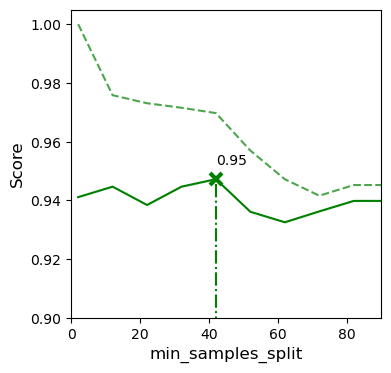

In [809]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 90)
ax.set_ylim(0.9, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(congress_min_samples_split_results["param_min_samples_split"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#, 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = congress_min_samples_split_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = reviews_min_samples_split_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(congress_min_samples_split_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = congress_min_samples_split_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/congress/congress_min_samples_split_var.svg')
plt.show()

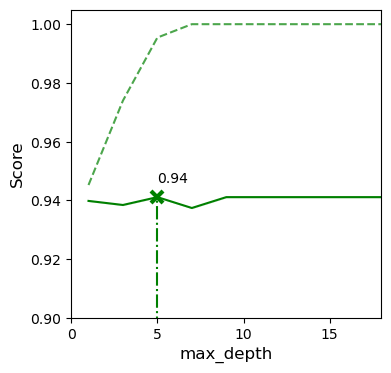

In [810]:
plt.figure(figsize=(4,4))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 18)
ax.set_ylim(0.9, 1.005)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(congress_max_depth_results["param_max_depth"].data, dtype=float)
scoring_list_plot=['balanced_accuracy']#, 'f1_weighted']
for scorer, color in zip(sorted(scoring_list_plot), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = congress_max_depth_results["mean_%s_%s" % (sample, scorer)]
        #sample_score_std = biomed_max_depth_results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean,# - sample_score_std,
            sample_score_mean,# + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (CV %s)" % (scorer, sample),
        )

    best_index = np.nonzero(congress_max_depth_results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = congress_max_depth_results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

#plt.legend(loc="best")
plt.grid(False)
#plt.savefig('data/congress/congress_max_depth_var.svg')
plt.show()

#### run RF with best accuracy hyperparameters on congress test sets

In [811]:
congress_best_balanced_accuracy_params=congress_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[0]

In [818]:
congress_rf_train_results.sort_values(by='balanced_accuracy', ascending=False)

,criterion,n_estimators,bootstrap,max_depth,max_features,min_samples_split,balanced_accuracy,accuracy,recall,recall_weighted,...,average_precision,precision_weighted,precision_micro,precision_macro,f1,f1_weighted,f1_micro,f1_macro,score_time,fit_time
177,entropy,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.021423,0.022860
285,log_loss,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020885,0.021263
321,log_loss,20,True,20,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020283,0.021379
69,gini,20,True,10,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.022470,0.021767
105,gini,20,True,20,None,10,0.969246,0.968076,NaN,0.968076,...,NaN,0.971455,0.968076,0.966869,NaN,0.968261,0.968076,0.966399,0.020065,0.021233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,gini,10,True,10,sqrt,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.020279,0.011633
12,gini,10,True,None,log2,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019191,0.011725
72,gini,10,True,20,sqrt,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019044,0.011601
48,gini,10,True,10,log2,2,0.930067,0.940381,NaN,0.940381,...,NaN,0.942824,0.940381,0.944421,NaN,0.939882,0.940381,0.935242,0.019340,0.011665


In [819]:
congress_best_balanced_accuracy_params=congress_rf_train_results.sort_values(by='balanced_accuracy', ascending=False).iloc[4]

In [820]:
x_train = x_congress_train_processed
y_train = y_congress_train
x_test = x_congress_test_processed
congress_best_balanced_accuracy_rf = RandomForestClassifier(criterion=congress_best_balanced_accuracy_params[0],
                            n_estimators=congress_best_balanced_accuracy_params[1],
                            bootstrap=congress_best_balanced_accuracy_params[2],
                            max_depth=congress_best_balanced_accuracy_params[3],
                            max_features=congress_best_balanced_accuracy_params[4],
                            min_samples_split=congress_best_balanced_accuracy_params[5],
                            random_state=chosen_random_state)
congress_best_balanced_accuracy_rf.fit(x_train,y_train)
congress_pred_best_balanced_accuracy_rf=congress_best_balanced_accuracy_rf.predict(x_test)
print('RF-Hyperparameters for best balanced accuracy \"Congress\":\n',congress_best_balanced_accuracy_params[0:6])
#print(best_weighted_recall_rf.predict(x_test))

RF-Hyperparameters for best balanced accuracy "Congress":
 criterion            gini
n_estimators           20
bootstrap            True
max_depth              20
max_features         None
min_samples_split      10
Name: 105, dtype: object


In [821]:
test=x_congress_test#_processed
test#.reset_index()
#test=pd.concat(x_congress_test['index'],congress_pred_best_balanced_accuracy_rf)

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
205,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
214,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
138,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
177,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
15,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
14,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
92,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
179,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,1.0


#### save prediction for best accuracy parameter set

In [822]:
congress_rf_test_results=x_congress_test_ID
congress_rf_test_results['class']=congress_pred_best_balanced_accuracy_rf

In [823]:
congress_rf_test_results.to_csv("data/congress/congress_rf_test_results.csv", index=False)
x_congress_test.reset_index()['index'].to_csv("data/congress/congress_rf_teeest_results.csv", index=False)

In [824]:
congress_rf_test_results

,ID,class
205,406,republican
214,278,republican
138,393,republican
177,136,republican
15,220,democrat
...,...,...
106,1,republican
14,59,republican
92,389,republican
179,292,democrat
